# **1. Install packages**

In [ ]:
%%capture
!pip install -U scikit-learn
!pip install catboost skimpy ppscore
!pip install -q ptitprince

# **2. Load libraries**

In [15]:
#========================================================
#                    Data manipulation
#========================================================
import pandas as pd
import numpy as np

#========================================================
#                    Data visualization
#========================================================
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
sns.set_style("darkgrid")
from skimpy import skim
import ptitprince as pt

#========================================================
#                    Stats
#========================================================
import ppscore as pps
from scipy import stats

#========================================================
#                    Data preprocessing
#========================================================
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#========================================================
#                    Models
#========================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, 
                              ExtraTreesRegressor, 
                              HistGradientBoostingRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#========================================================
#                    Metrics
#========================================================
from sklearn.metrics import root_mean_squared_log_error

#========================================================
#                    Others
#========================================================
from collections import Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# **3. Load data**

In [2]:
data = pd.read_csv("/kaggle/input/customer-purchasing-behaviors/Customer Purchasing Behaviors.csv")
data.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,North,12
1,2,34,55000,350,7.0,South,18
2,3,45,65000,500,8.0,West,22
3,4,22,30000,150,3.0,East,10
4,5,29,47000,220,4.8,North,13


In [3]:
print(f'Data: rows = {data.shape[0]} and cols = {data.shape[1]}')

Data: rows = 238 and cols = 7


# **4. EDA**

Let's divide our data set into three blocks:

- **Train**: based on this data set we will perform our EDA and train our models.
- **Validation**: it will help us evaluate our model and tune the hyperparameters.
- **Test**: to simulate as if it were real data that is arriving and we predict, this data is only used to predict them.

In [4]:
SEED = 42
data_train, data_rest = train_test_split(data, 
                                         test_size = 0.3, 
                                         random_state = SEED)
data_valid, data_test = train_test_split(data_rest, 
                                         test_size = 0.5, 
                                         random_state = SEED)

print(f"Data train: {data_train.shape[0]} samples")
print(f"Data valid: {data_valid.shape[0]} samples")
print(f"Data test: {data_test.shape[0]} samples")

Data train: 166 samples
Data valid: 36 samples
Data test: 36 samples


In [5]:
skim(data_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 166    │ │ int64       │ 5     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ user_id               │   0 │     0 │  117.6 │  68.99 │      1 │   55.5 │  118.5 │  174.5 │   238 │ ▇▇▇▇▇▇ │  │
│ │ age                   │   0 │     0 │  38.72 │   9.16 │     22 │     31 │     39 │     46 │    55 │ ▆▇▇▇▆▇ │  │
│ │ annual_income         │   0 │     0 │  57670 │  10840 │  30000 │  51000 │  58000 │  66000 │ 75000 │ ▂▂▆▇▇▇ │  │
│ │ purchase_amount       │   0 │     0 │  428.8 │  135.6 │    150 │    340 │    440 │    520 │   640 │ ▃▅▆▇▇▇ │  │
│ │ loyalty_score         │   0 │     0 │  6.837 │  1.836 │      3 │    5.6 │      7 │    8.2 │   9.5 │ ▃▅▅▅▆▇ │  │
│ │ purchase_frequency    │   0 │     0 │  19.88 │  4.401 │     10 │     17 │     20 │     23 │    28 │ ▂▅▇▇▆▆ │  │
│ └───────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ region                    │       0 │          0 │                            1 │                      166 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

We are going to make two configurations:
- we remove the column **`user_id`**.
- we convert the column **`region`** from type **object** to type **category**.

In [6]:
data_train = data_train.drop(columns = ['user_id'])
data_valid = data_valid.drop(columns = ['user_id'])
data_test = data_test.drop(columns = ['user_id'])

In [7]:
data_train['region'] = data_train['region'].astype('category')
data_valid['region'] = data_valid['region'].astype('category')
data_test['region'] = data_test['region'].astype('category')

In [8]:
# Now if we visualize our training data.
skim(data_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 166    │ │ int64       │ 4     │ │ region                │                                │
│ │ Number of columns │ 6      │ │ float64     │ 1     │ └───────────────────────┘                                │
│ └───────────────────┴────────┘ │ category    │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ age                   │   0 │     0 │  38.72 │   9.16 │     22 │     31 │     39 │     46 │    55 │ ▆▇▇▇▆▇ │  │
│ │ annual_income         │   0 │     0 │  57670 │  10840 │  30000 │  51000 │  58000 │  66000 │ 75000 │ ▂▂▆▇▇▇ │  │
│ │ purchase_amount       │   0 │     0 │  428.8 │  135.6 │    150 │    340 │    440 │    520 │   640 │ ▃▅▆▇▇▇ │  │
│ │ loyalty_score         │   0 │     0 │  6.837 │  1.836 │      3 │    5.6 │      7 │    8.2 │   9.5 │ ▃▅▅▅▆▇ │  │
│ │ purchase_frequency    │   0 │     0 │  19.88 │  4.401 │     10 │     17 │     20 │     23 │    28 │ ▂▅▇▇▆▆ │  │
│ └───────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA        ┃ NA %           ┃ ordered               ┃ unique             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ region                           │         0 │              0 │ False                 │                  4 │  │
│ └──────────────────────────────────┴───────────┴────────────────┴───────────────────────┴────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Let's start with a **univariate** analysis, then **bivariate** and finally **multivariate**.

- **Univariate Analysis**

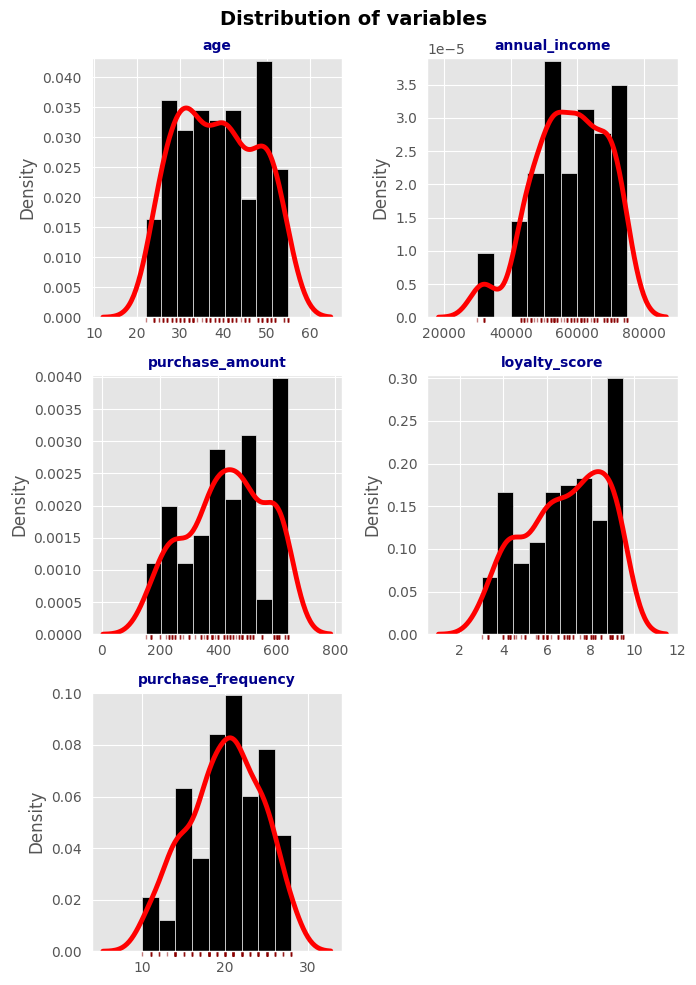

In [81]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (7, 10))
axes = axes.flat

for i, col, in enumerate(data_train.select_dtypes(include = ['int', 'float']).columns):
    sns.histplot(data = data_train, 
                 x = col, 
                 stat = 'density', 
                 fill = True, 
                 color = 'black', 
                 alpha = 1.0,
                 ax = axes[i]) 
    sns.kdeplot(data = data_train, 
                x = col, 
                color = 'red', 
                lw = 3.5, 
                ax = axes[i])
    sns.rugplot(data = data_train, 
                x = col, 
                height = -.02, 
                clip_on = False, 
                color = 'darkred', 
                alpha = 0.5, 
                ax = axes[i])
    axes[i].set_xlabel("")
    axes[i].set_title(f"{col}", fontsize = 10, fontweight = 'bold', color = 'darkblue')
   
fig.suptitle("Distribution of variables", fontsize = 14, fontweight = 'bold', color = 'black')
fig.tight_layout()
fig.delaxes(ax = axes[5])
fig.show()

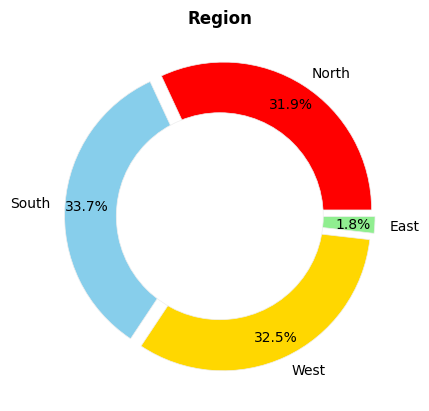

In [56]:
plt.pie(x = Counter(data_train['region']).values(), 
        labels = Counter(data_train['region']).keys(), 
        colors = ['red', 'skyblue', 'gold', 'lightgreen'],
        autopct = "%1.1f%%", 
        explode = (.05, .05, .05, .05), 
        pctdistance = 0.85, 
        textprops = {'color':'black'})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Region", fontsize = 12, fontweight = 'bold', color = 'black')
plt.show()

- **Bivariate Analysis**

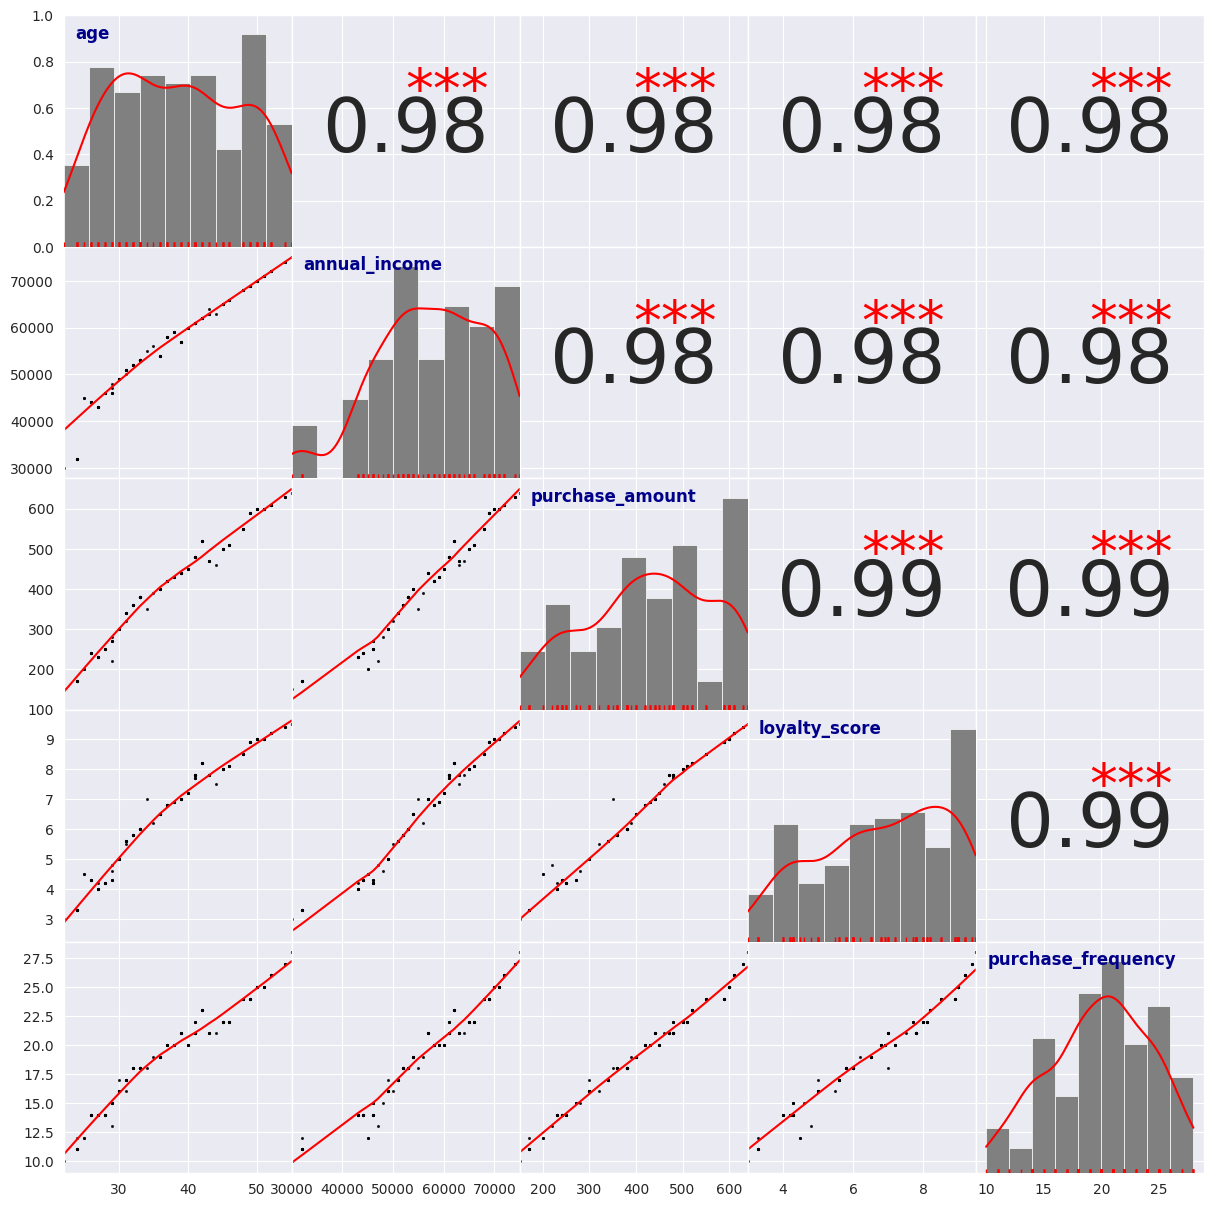

In [16]:
def histogram(x, **kws):
    ax = sns.histplot(x=x, color='grey', kde=True, alpha = 1.0)
    ax.lines[0].set_color('red')
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes, fontweight='bold', color = 'darkblue', fontsize = 12)
    
def rugplot(x, **kws):
    ax = sns.rugplot(x = x, color = 'red', height = .02, alpha = 1.0)

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.5, 0.6), xycoords=ax.transAxes, color='red', fontsize=40)

g = sns.PairGrid(data_train.select_dtypes(include = ['int', 'float']), diag_sharey = False, despine = False, dropna = True)

g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'red', 'lw': 1.5}, scatter_kws={'color': 'black', 's': 1.5})

g.map_diag(histogram)
g.map_diag(rugplot)
g.map_upper(corrdot)
g.map_upper(corrfunc)

g.fig.subplots_adjust(wspace=0, hspace=0)

for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

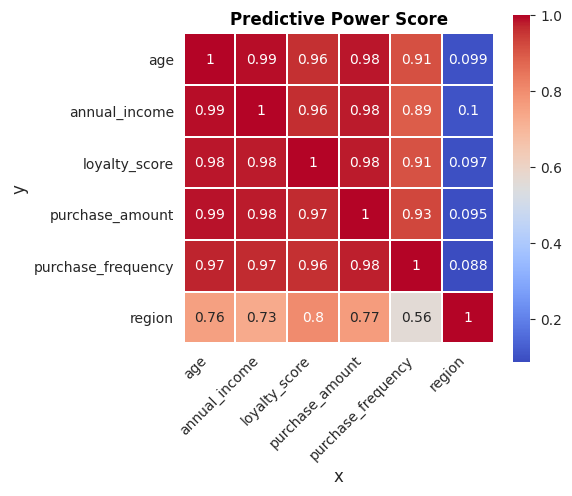

In [17]:
pps_matrix = pps.matrix(data_train)[['x', 'y', 'ppscore']].pivot(values = 'ppscore', 
                                                           index = 'y', 
                                                           columns = 'x')
fig,ax = plt.subplots(figsize = (5, 4.5))
sns.heatmap(pps_matrix, 
            annot = True, 
            cmap = 'coolwarm', 
            square = True,
            linewidths = 1.3,
            ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
ax.set_title("Predictive Power Score", fontsize = 12, fontweight = 'bold', color = 'black')
fig.show()

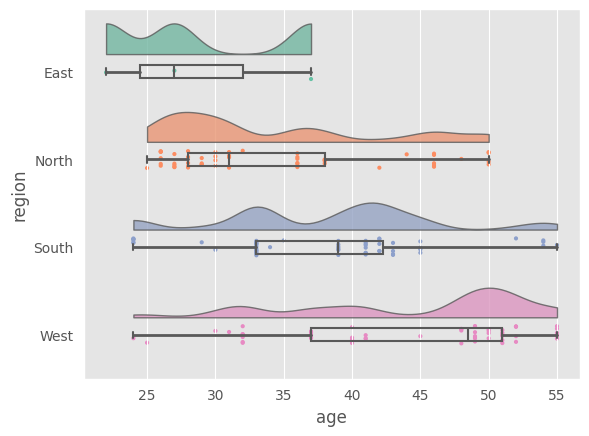

In [70]:
pt.RainCloud(x = 'region', y = 'age', data = data_train, orient = 'h', alpha = 0.8)
plt.show()

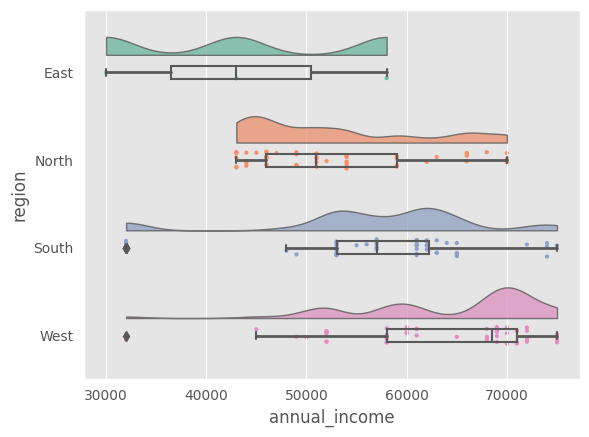

In [71]:
pt.RainCloud(x = 'region', y = 'annual_income', data = data_train, orient = 'h', alpha = 0.8)
plt.show()

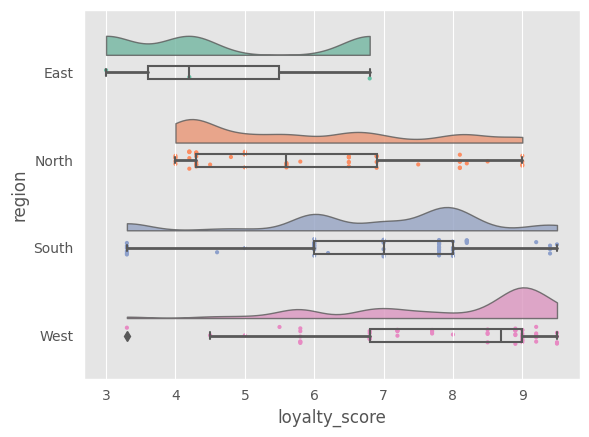

In [72]:
pt.RainCloud(x = 'region', y = 'loyalty_score', data = data_train, orient = 'h', alpha = 0.8)
plt.show()

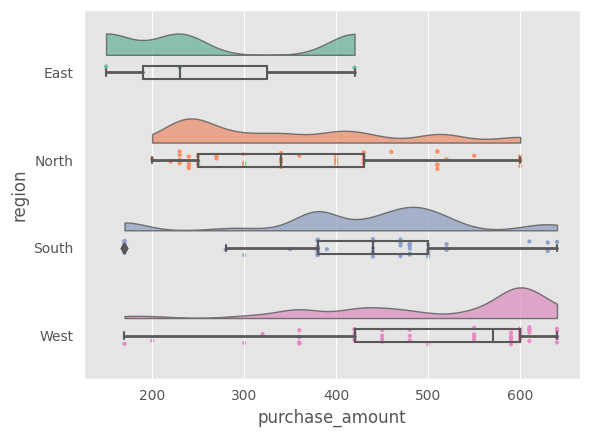

In [73]:
pt.RainCloud(x = 'region', y = 'purchase_amount', data = data_train, orient = 'h', alpha = 0.8)
plt.show()

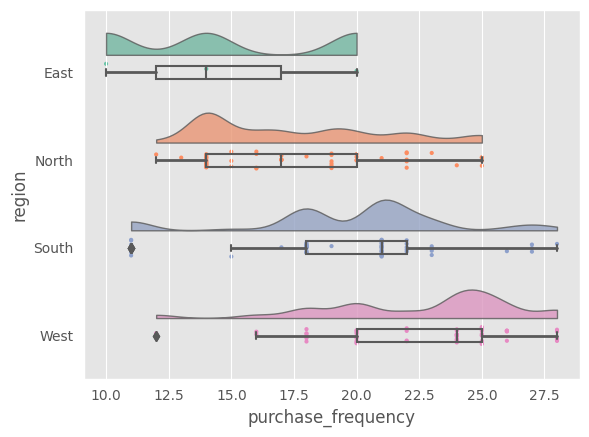

In [74]:
pt.RainCloud(x = 'region', y = 'purchase_frequency', data = data_train, orient = 'h', alpha = 0.8)
plt.show()

- **Multivariate Analysis**

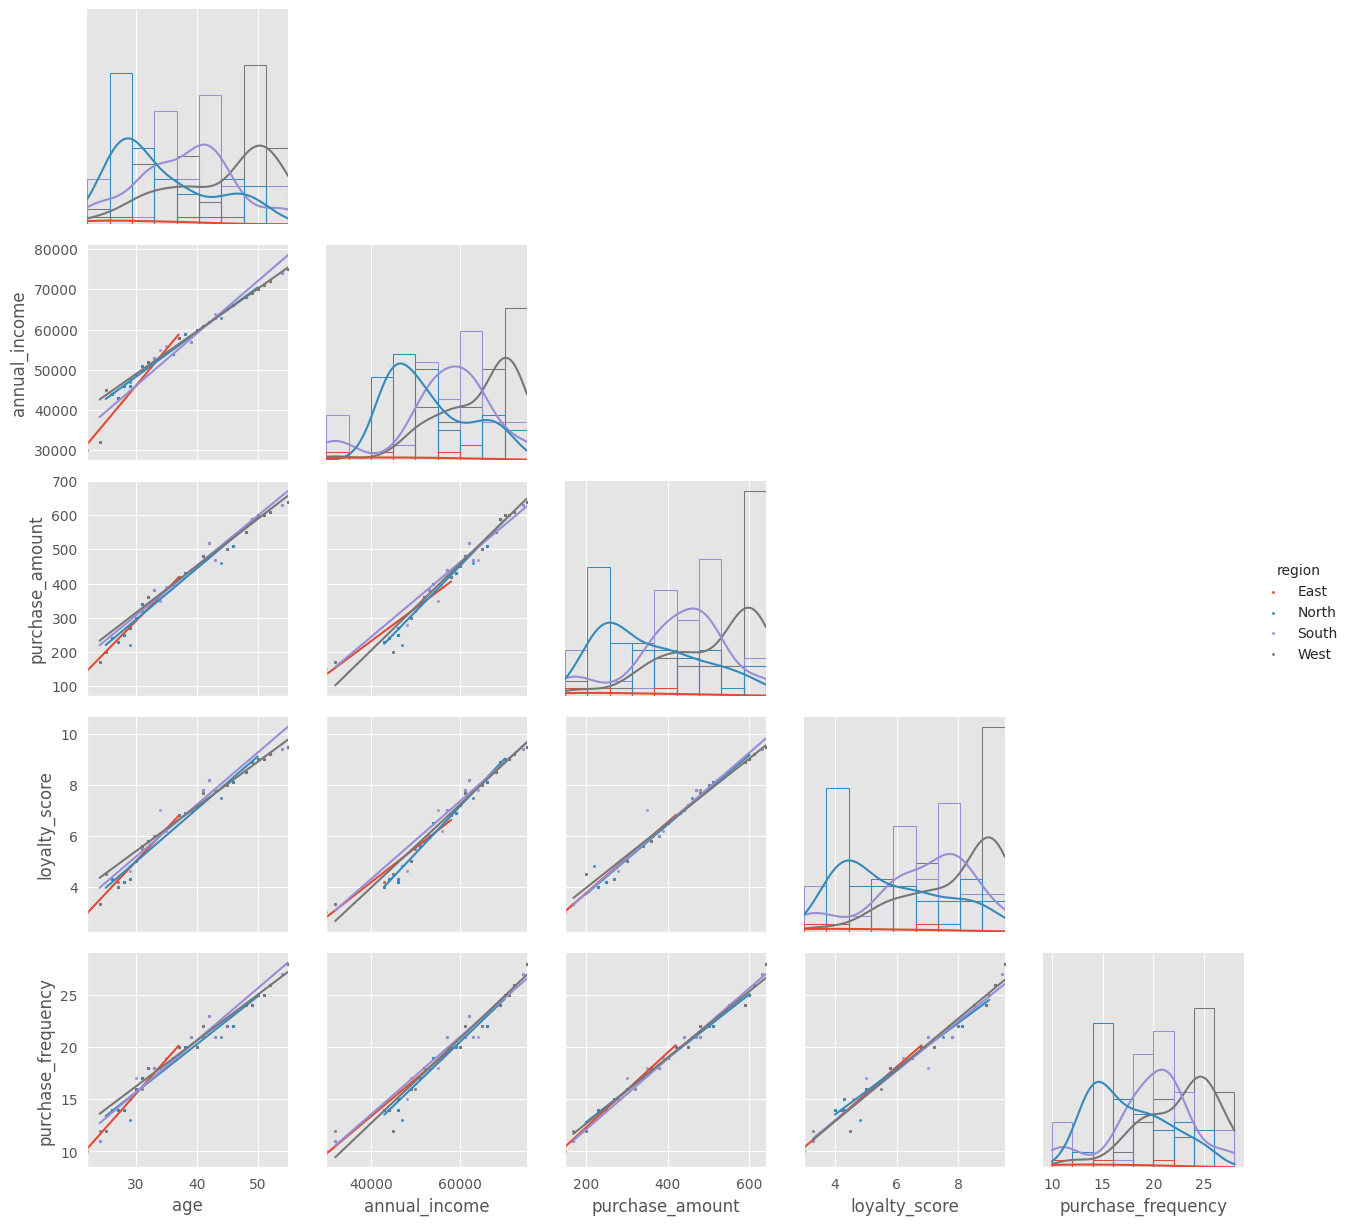

In [79]:
g = sns.PairGrid(data_train, hue = 'region', vars = data_train.select_dtypes(include = ['int', 'float']), corner = True)
g.map_lower(sns.regplot, ci = False, line_kws={'lw': 1.5}, scatter_kws={'s': 1.5})
g.map_diag(sns.histplot, kde = True, fill = False)
g.add_legend()
g.fig.show()

# **5. Data preprocessing**

In [18]:
X_train, y_train = data_train.drop(columns = 'loyalty_score'), data_train['loyalty_score']
X_valid, y_valid = data_valid.drop(columns = 'loyalty_score'), data_valid['loyalty_score']
X_test, y_test = data_test.drop(columns = 'loyalty_score'), data_test['loyalty_score']

In [19]:
categorical_feature = X_train.select_dtypes(include = ['category']).columns.to_list()

In [20]:
preprocessor = ColumnTransformer(transformers = [('encoder', 
                                                  OneHotEncoder(drop = 'first', 
                                                                sparse_output = False, 
                                                                handle_unknown = 'ignore'), 
                                                  categorical_feature)], 
                                remainder = 'passthrough', 
                                verbose_feature_names_out = False)
preprocessor.set_output(transform = 'pandas')
X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)

# **6. Models**

In [22]:
reg1 = DecisionTreeRegressor(random_state = SEED)
reg2 = RandomForestRegressor(random_state = SEED)
reg3 = ExtraTreesRegressor(random_state = SEED, bootstrap = True)
reg4 = HistGradientBoostingRegressor(random_state = SEED)
reg5 = XGBRegressor(random_state = SEED)
reg6 = LGBMRegressor(random_state = SEED, verbosity = -1)
reg7 = CatBoostRegressor(random_seed = SEED, verbose = 0)

REGRESSORS = [reg1, reg2, reg3, reg4, reg5, reg6, reg7]

In [23]:
scores_train = {}
scores_valid = {}

for model in tqdm(REGRESSORS):
    name_model = type(model).__name__
    
    model.fit(X_train_prep, y_train)
    
    y_pred_train = model.predict(X_train_prep)
    y_pred_valid = model.predict(X_valid_prep)
    
    scores_train[name_model] = root_mean_squared_log_error(y_train, y_pred_train)
    scores_valid[name_model] = root_mean_squared_log_error(y_valid, y_pred_valid)
    
    print(f"* {name_model} finished!!\n")

  0%|          | 0/7 [00:00<?, ?it/s]

* DecisionTreeRegressor finished!!

* RandomForestRegressor finished!!

* ExtraTreesRegressor finished!!

* HistGradientBoostingRegressor finished!!

* XGBRegressor finished!!

* LGBMRegressor finished!!

* CatBoostRegressor finished!!



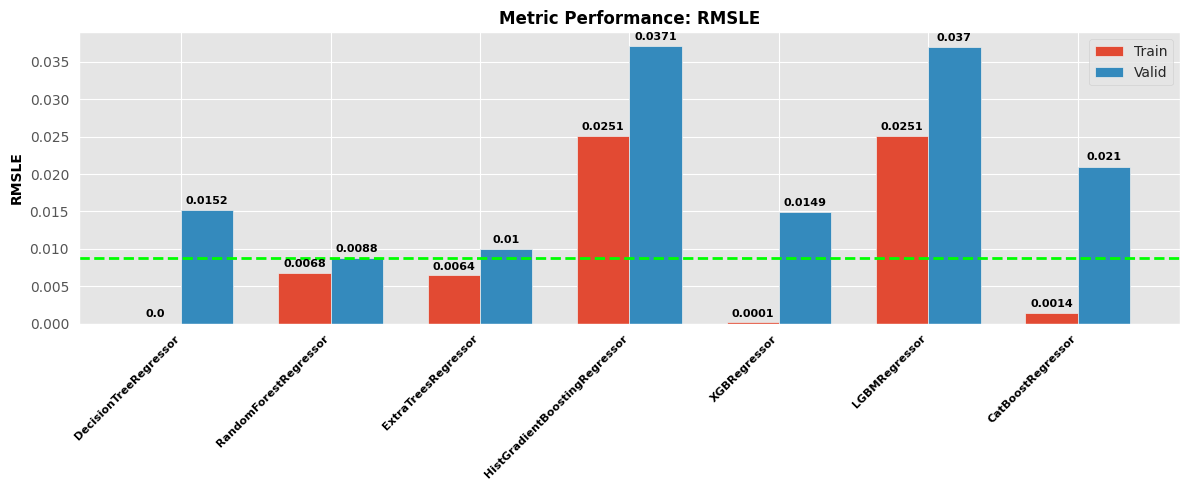

In [61]:
name_models = list(scores_train.keys())
rmsle_train = list(scores_train.values())
rmsle_valid = list(scores_valid.values())

x = np.arange(len(name_models))

width = 0.35

fig,ax = plt.subplots(figsize = (12, 5))

rects1 = ax.bar(x - width/2, rmsle_train, width = width, label = 'Train')
rects2 = ax.bar(x + width/2, rmsle_valid, width = width, label = 'Valid')

ax.set_ylabel("RMSLE", fontsize = 10, fontweight = 'bold', color = 'black')
ax.set_title("Metric Performance: RMSLE", fontsize = 12, fontweight = 'bold', color = 'black')
ax.set_xticks(x)
ax.set_xticklabels(name_models, rotation = 45, horizontalalignment = 'right', fontsize = 8, color = 'black', fontweight = 'bold')
ax.axhline(y = min(scores_valid.values()), lw = 2.0, linestyle = '--', color = 'lime')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = round(rect.get_height(), 4)
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight = 'bold', color = 'black', fontsize = 8)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
fig.show()

The best model is **RandomForestRegressor**.

In [28]:
# We perform preprocessing on our test set.
X_test_prep = preprocessor.transform(X_test)
X_test_prep.head()

,region_North,region_South,region_West,age,annual_income,purchase_amount,purchase_frequency
6,0.0,0.0,1.0,36,54000,400,19
66,1.0,0.0,0.0,50,70000,600,25
86,0.0,0.0,1.0,32,52000,360,18
115,0.0,1.0,0.0,54,74000,630,27
75,1.0,0.0,0.0,28,46000,250,14


In [54]:
# We again instantiate the model and make predictions on the test set.
model = RandomForestRegressor(random_state = SEED)
model.fit(X_train_prep, y_train)

y_pred_test = model.predict(X_test_prep)
rmsle_test = root_mean_squared_log_error(y_test.values, y_pred_test)
print(f"RMSLE: {rmsle_test:.4f}")

RMSLE: 0.0027
